# check results by some metrics

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from tqdm import tqdm
import gc
import pprint
from IPython.display import display
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## download datasets

In [2]:
def str_predictions_to_tensor(value):
    list_values = value.strip('[]').split(', ')
    cleaned_list_values = [float(item) for item in list_values]
    return cleaned_list_values

In [3]:
def str_tags_to_tensor(value):
    value = int(value)
    return value

In [4]:
folder_path = '../results/2024-04-21-lstm/predictions_vs_tags'

results_dfs = {}

subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

for subfolder in subfolders:
    subfolder_name = os.path.basename(subfolder)
    results_dfs[subfolder_name] = {}
    
    for file in os.listdir(subfolder):
        if file.endswith('.csv'):
            
            file_name = int(os.path.splitext(os.path.basename(file))[0])
            file_path = os.path.join(subfolder, file)
            
            df = pd.read_csv(file_path, converters={"train_predictions": str_predictions_to_tensor, 'test_predictions': str_predictions_to_tensor, 'train_tags': str_tags_to_tensor, 'test_tags': str_tags_to_tensor})
            
            results_dfs[subfolder_name][file_name] = df

## take labels

In [5]:
def str_text_to_list(value):
    list_values = value.strip('[]').split(', ')
    cleaned_list_values = [item[1:-1] for item in list_values]
    return cleaned_list_values

In [6]:
dataset_wsd_1 = pd.read_csv("../datasets/tonetags_wsd_1.csv", index_col=0, converters={"text": str_text_to_list})

classes = dataset_wsd_1.tags.unique().tolist()
num_classes = len(classes)

del dataset_wsd_1
gc.collect()

0

In [7]:
num_classes

19

## plot function

In [55]:
def plot_function(dataset_name, metric_name, train_metric, test_metric, epochs):
    plt.figure(figsize=(20, 6))
    plt.plot(epochs, train_metric, label=f'Train', linewidth=3, color='green')
    plt.plot(epochs, test_metric, label='Test', linewidth=3, color='purple')
    plt.xticks(range(min(epochs), max(epochs) + 1, 1))
    plt.ylim(min(train_metric + test_metric) - 0.02, max(train_metric + test_metric) + 0.02)
    plt.legend(loc='upper left')
    plt.grid(linestyle='--')
    plt.xlabel('Number of epochs', fontsize=20)
    plt.ylabel(f'{metric_name} value', fontsize=20)
    plt.title(f'LSTM {metric_name} train vs. test for {dataset_name} dataset. Metric in sweetspot 11 = {test_metric[10].item()}', fontsize=20)
    plt.show()

## calculate metrics

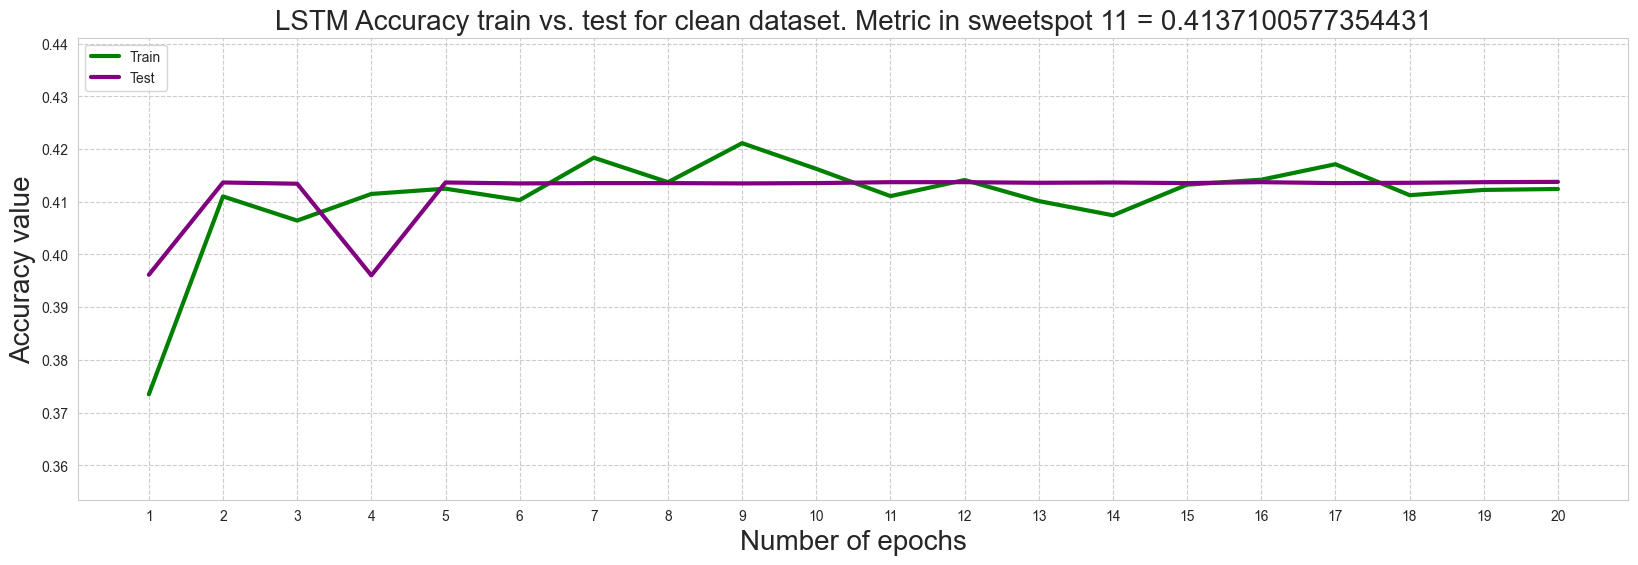

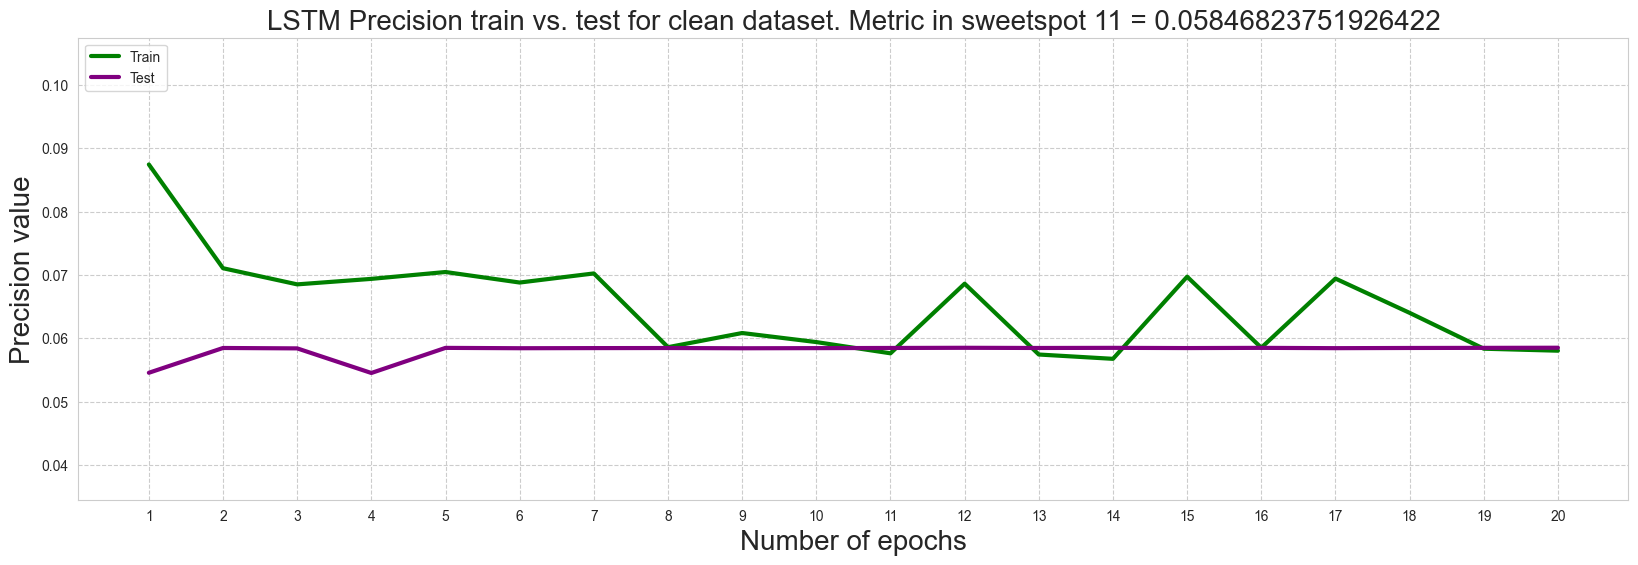

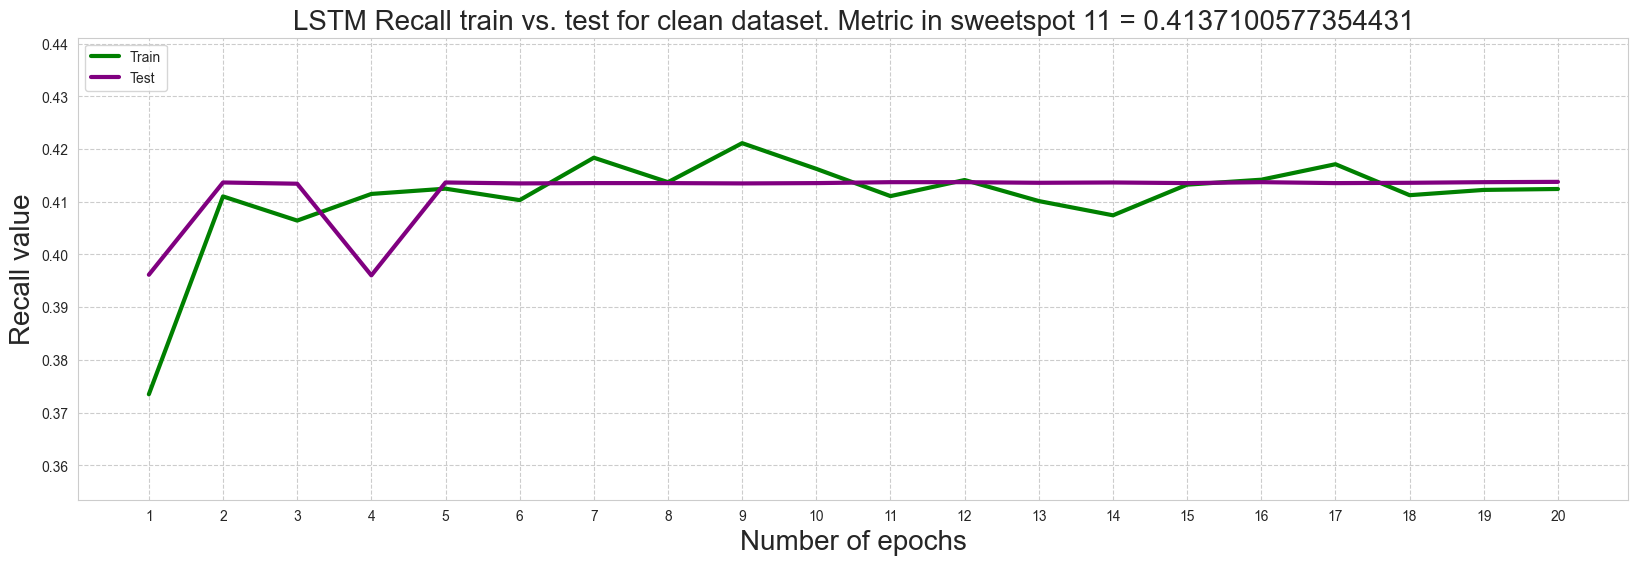

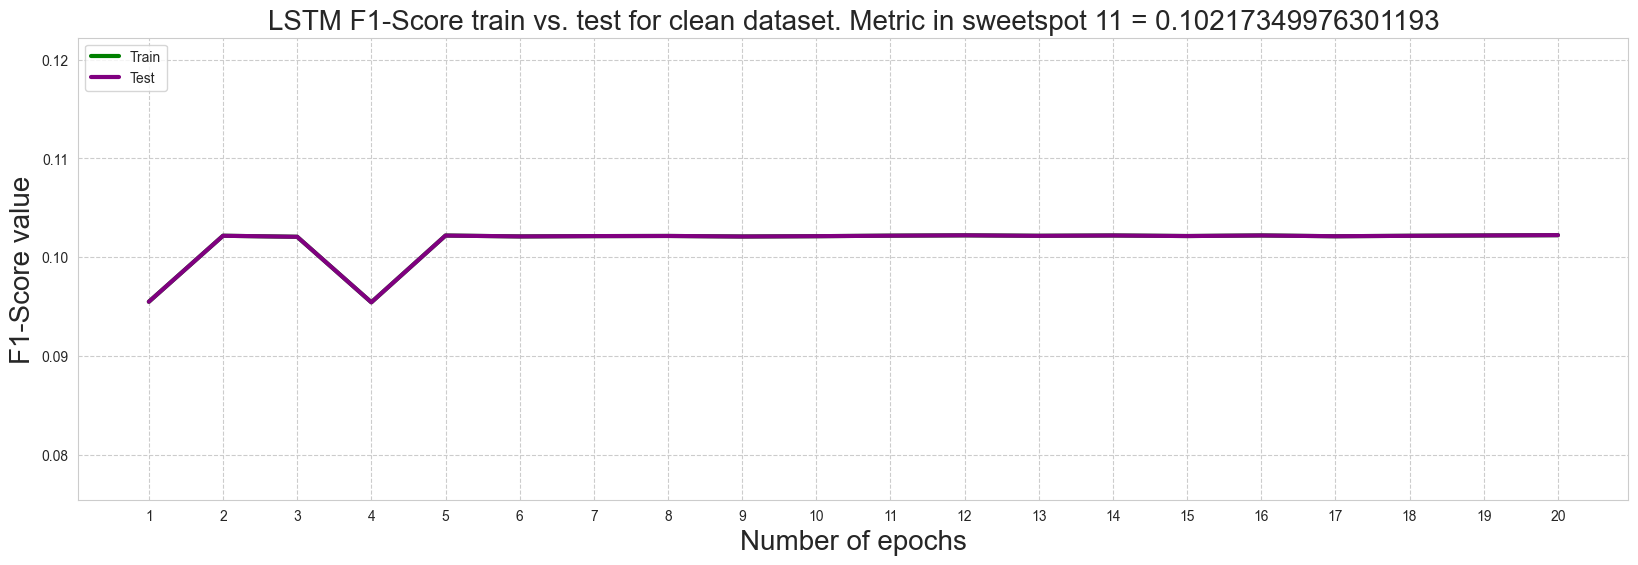

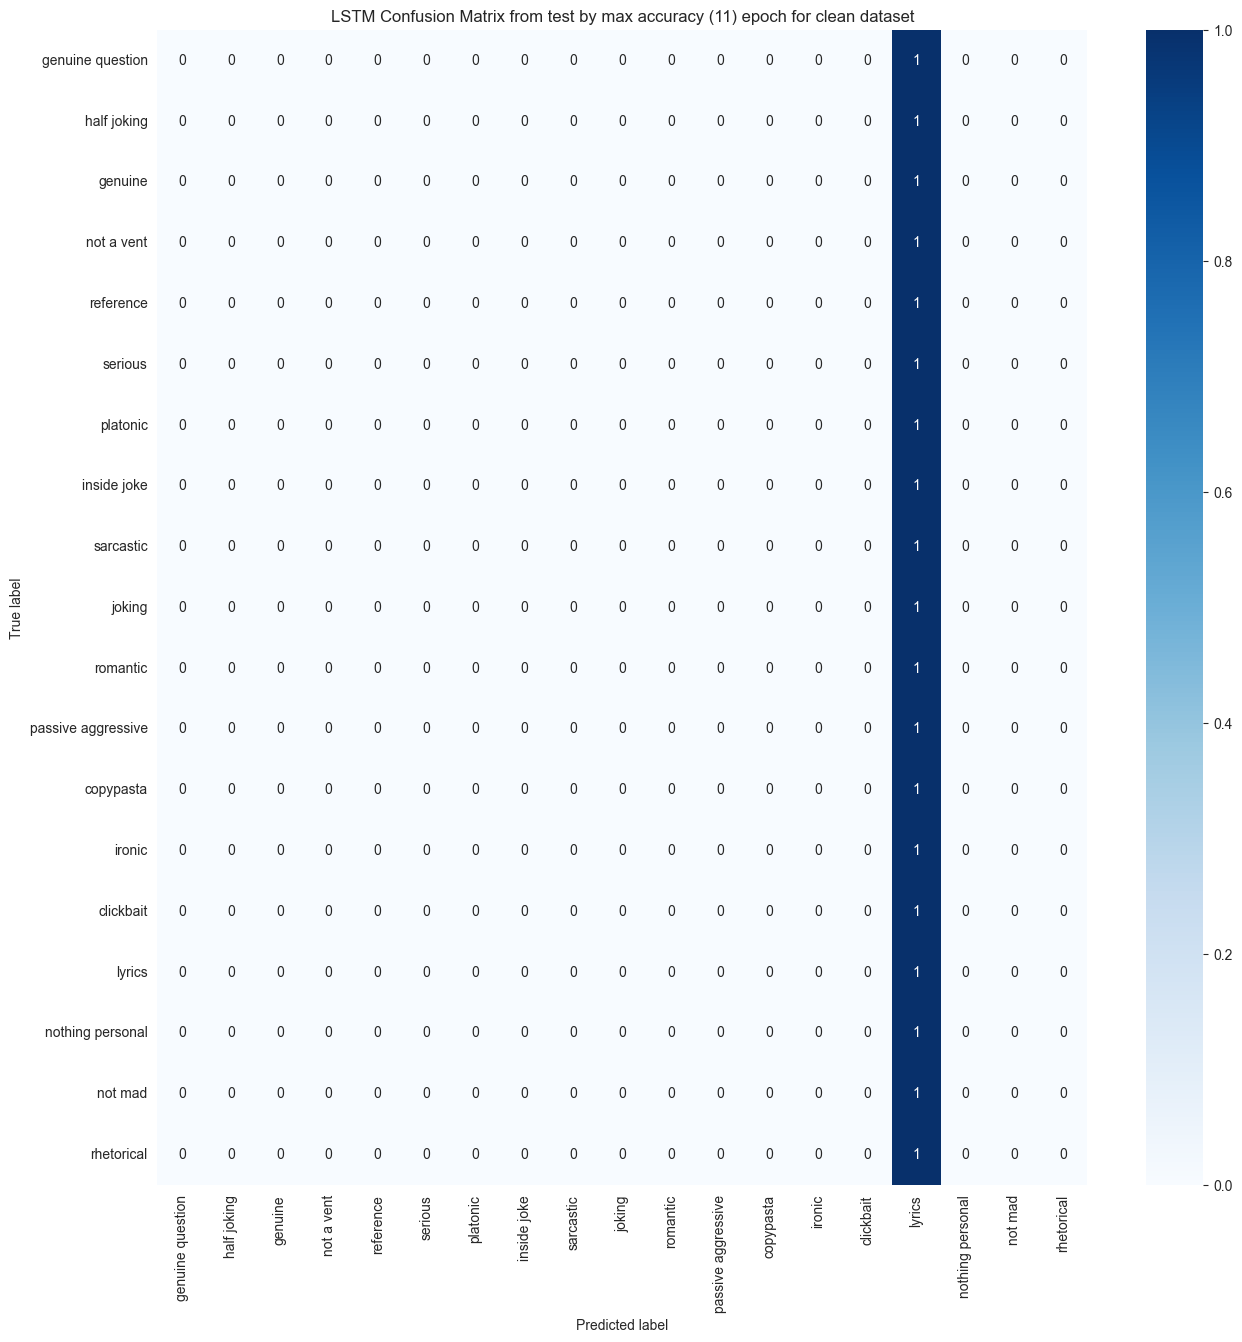

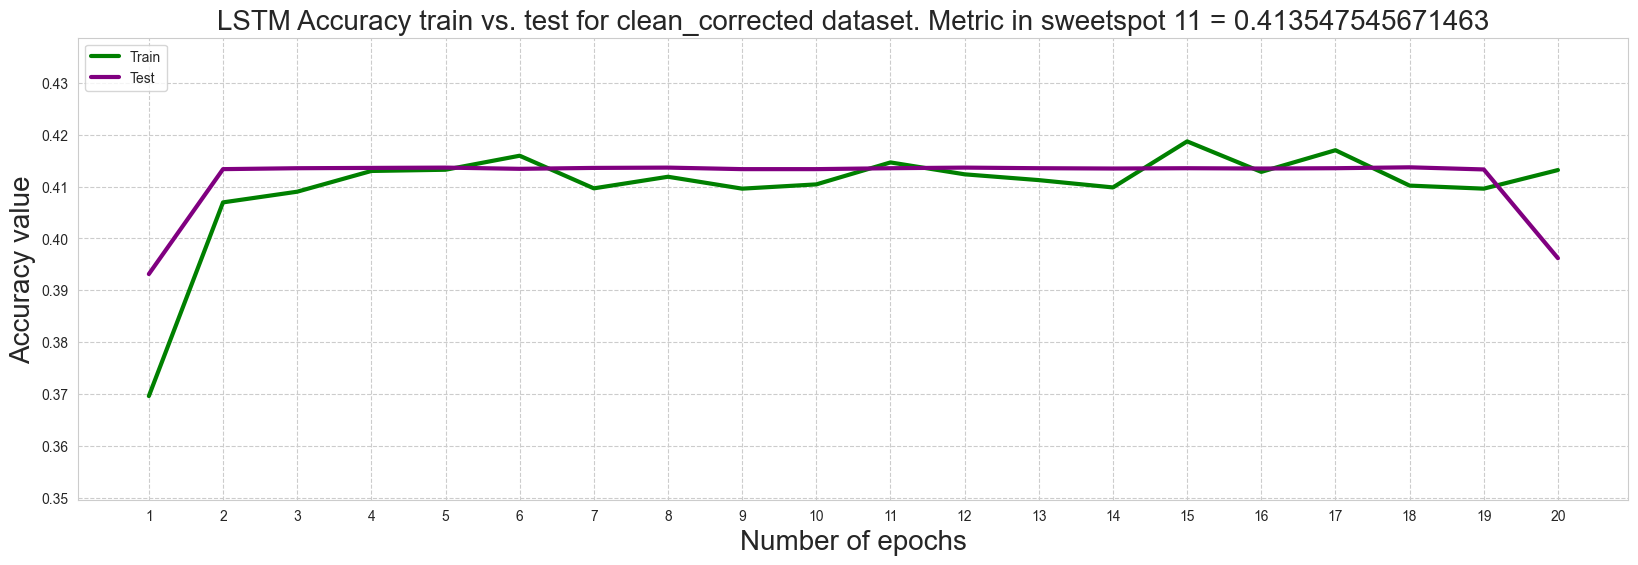

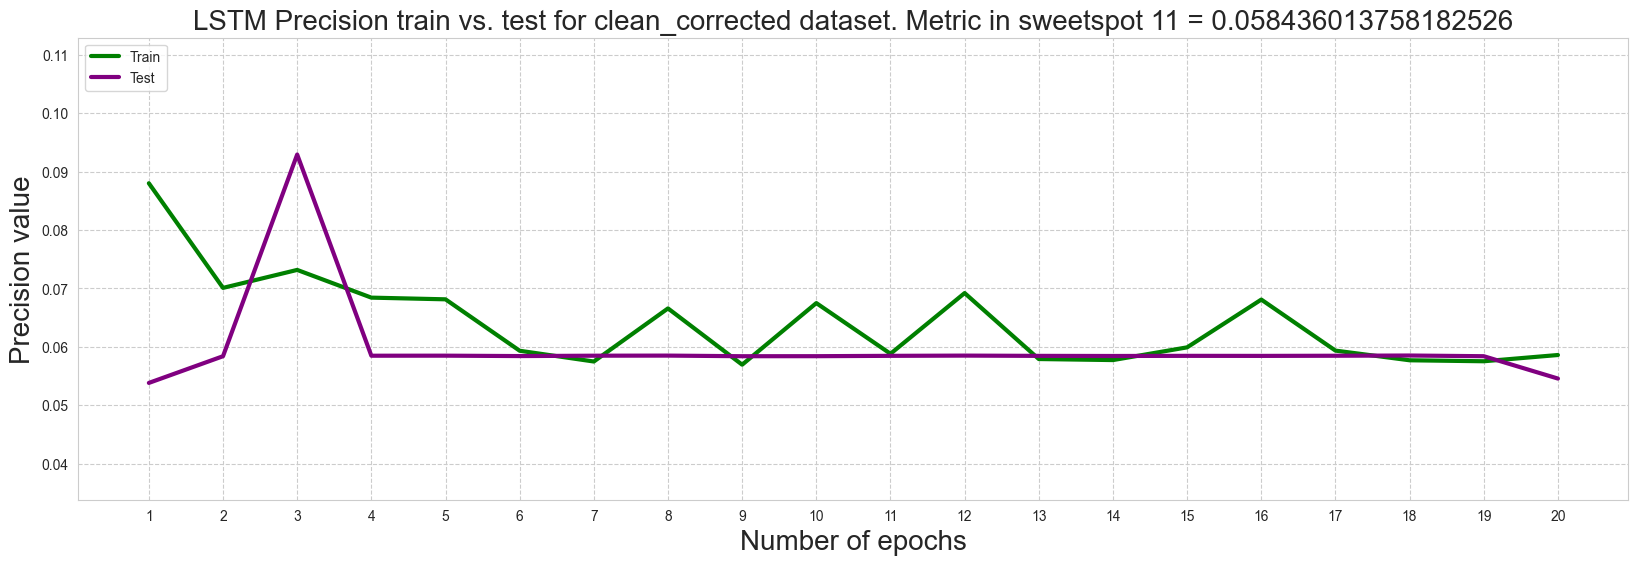

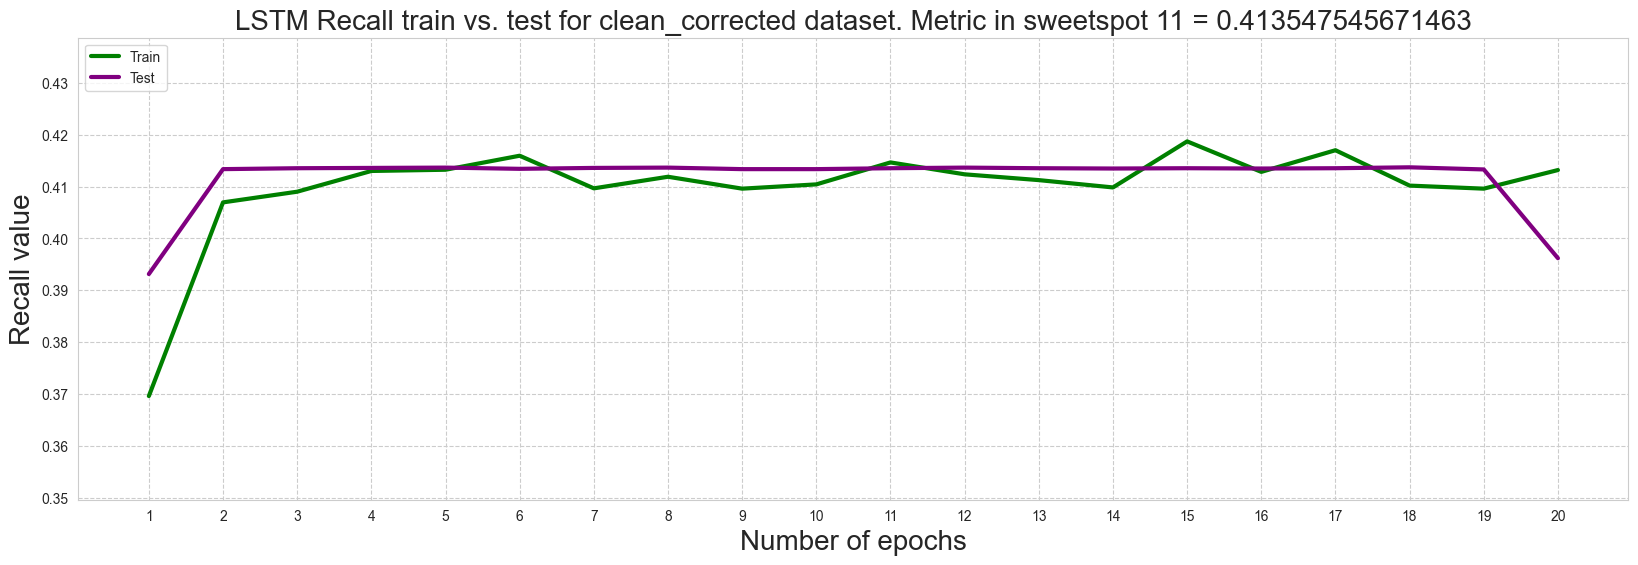

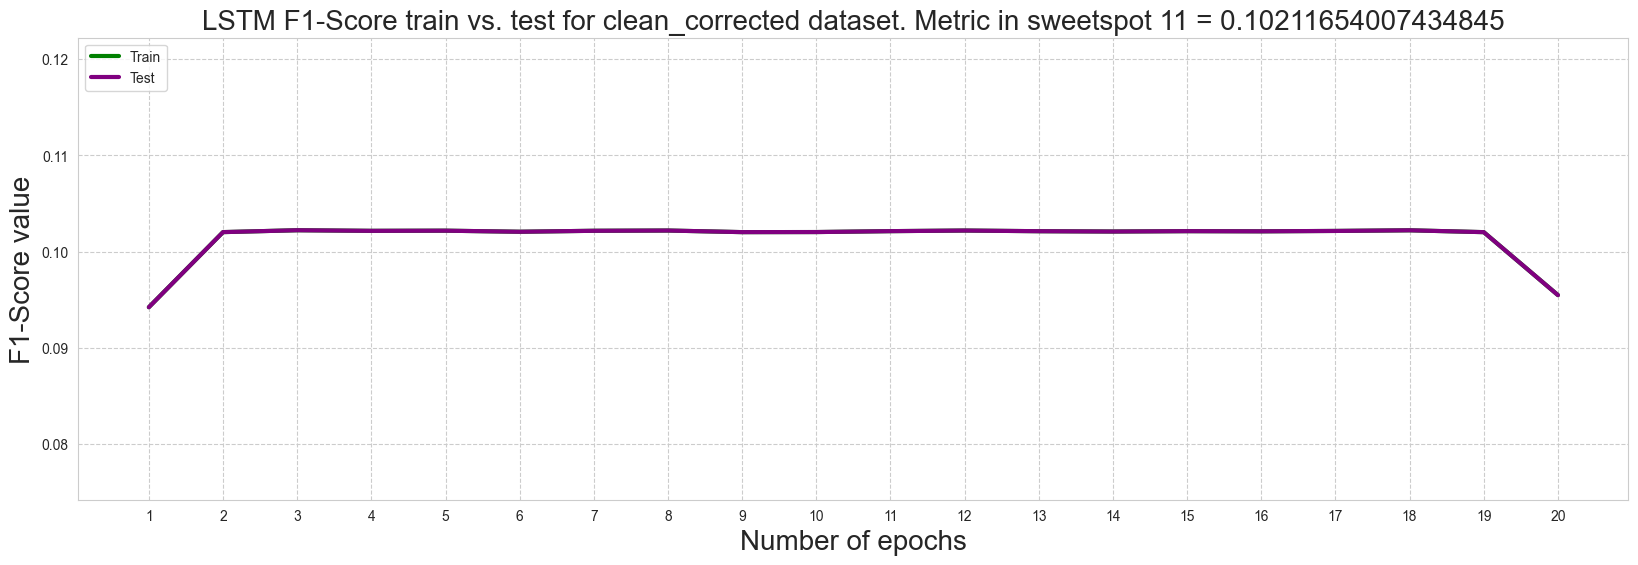

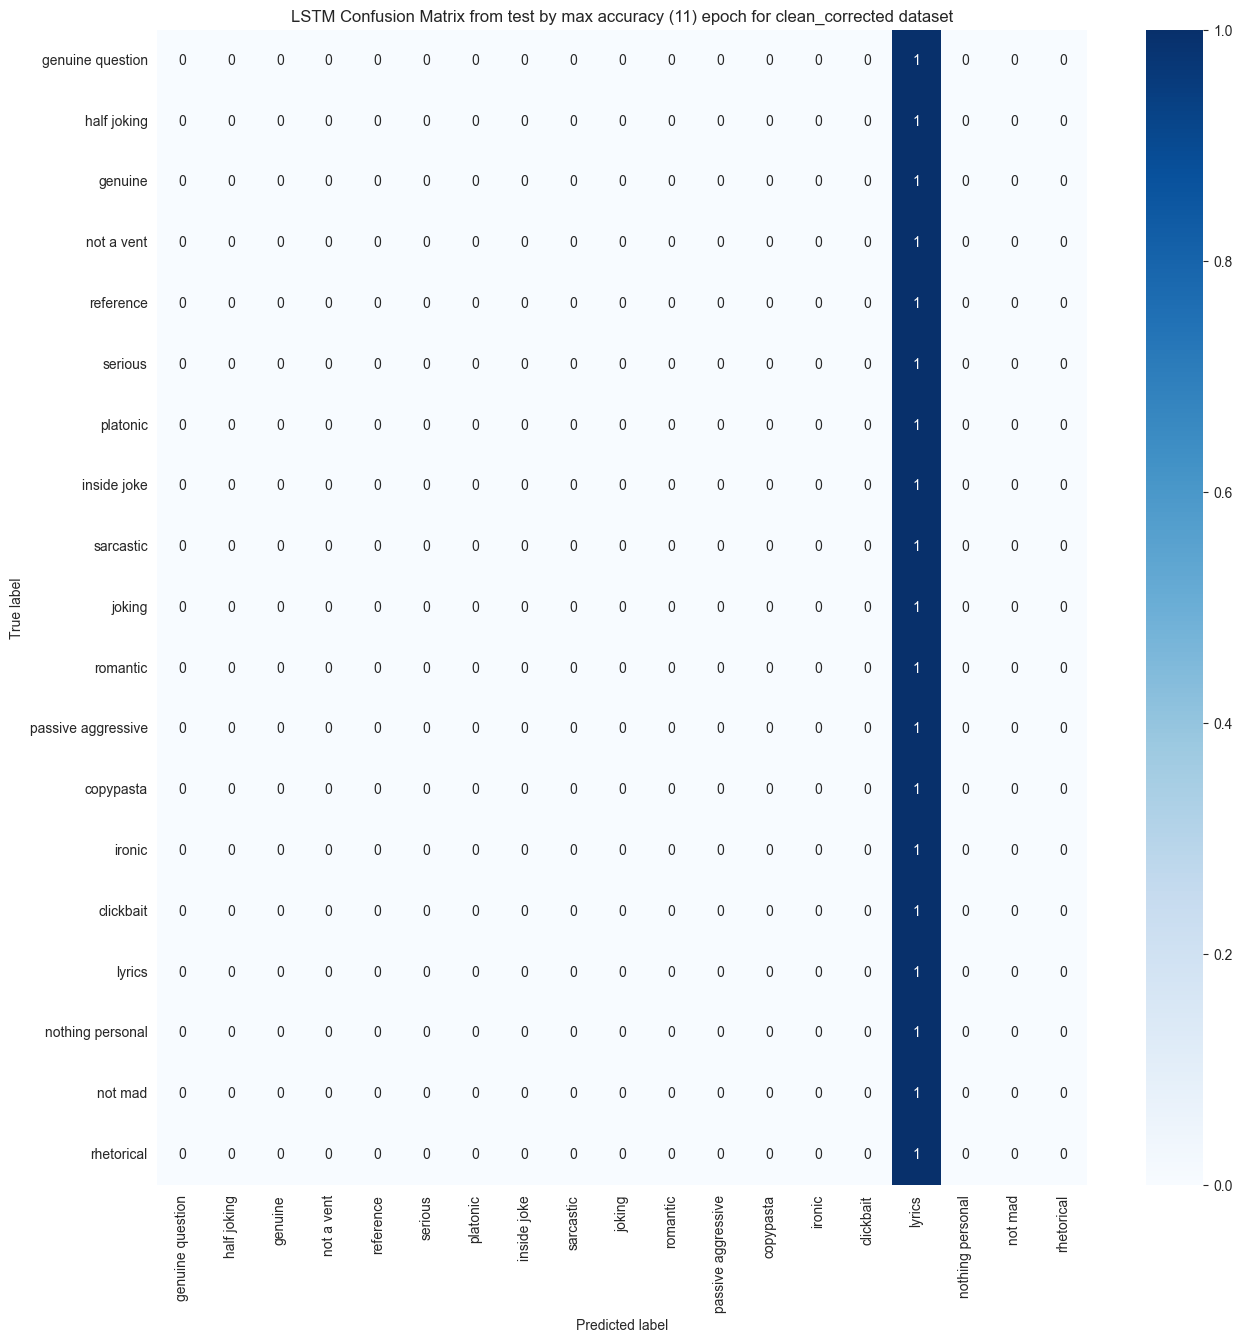

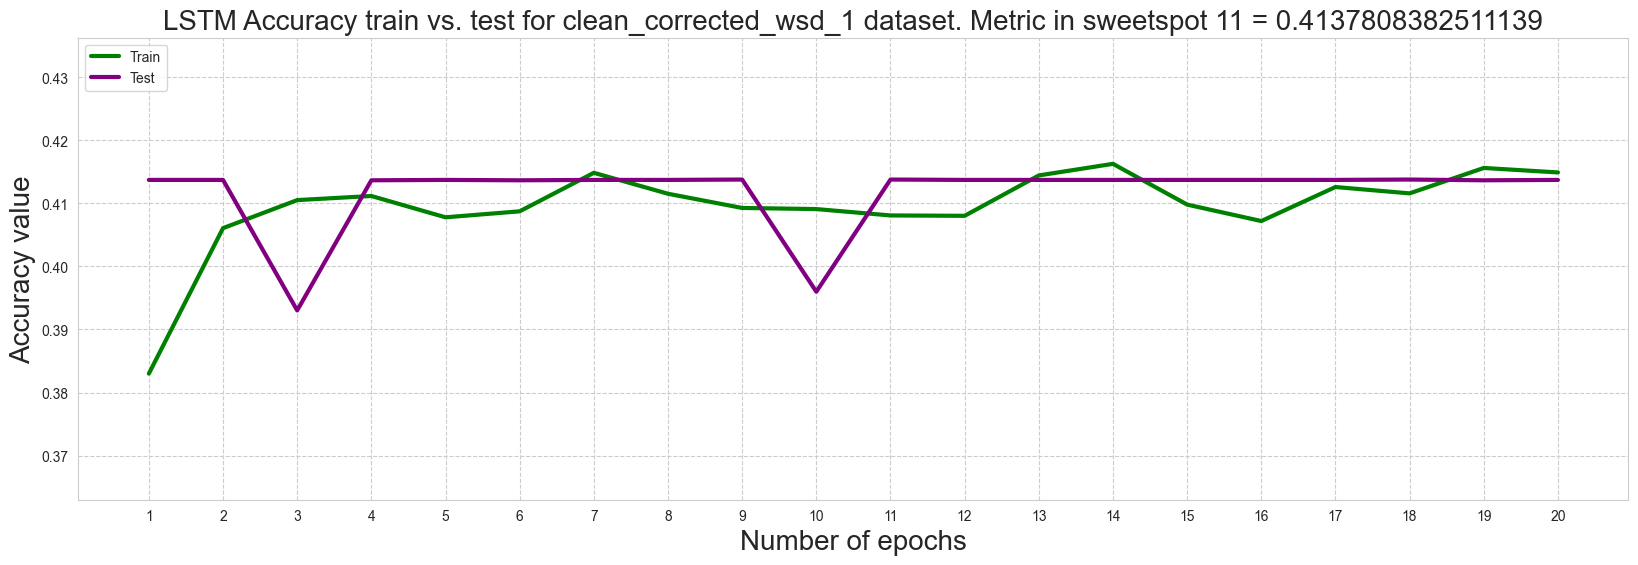

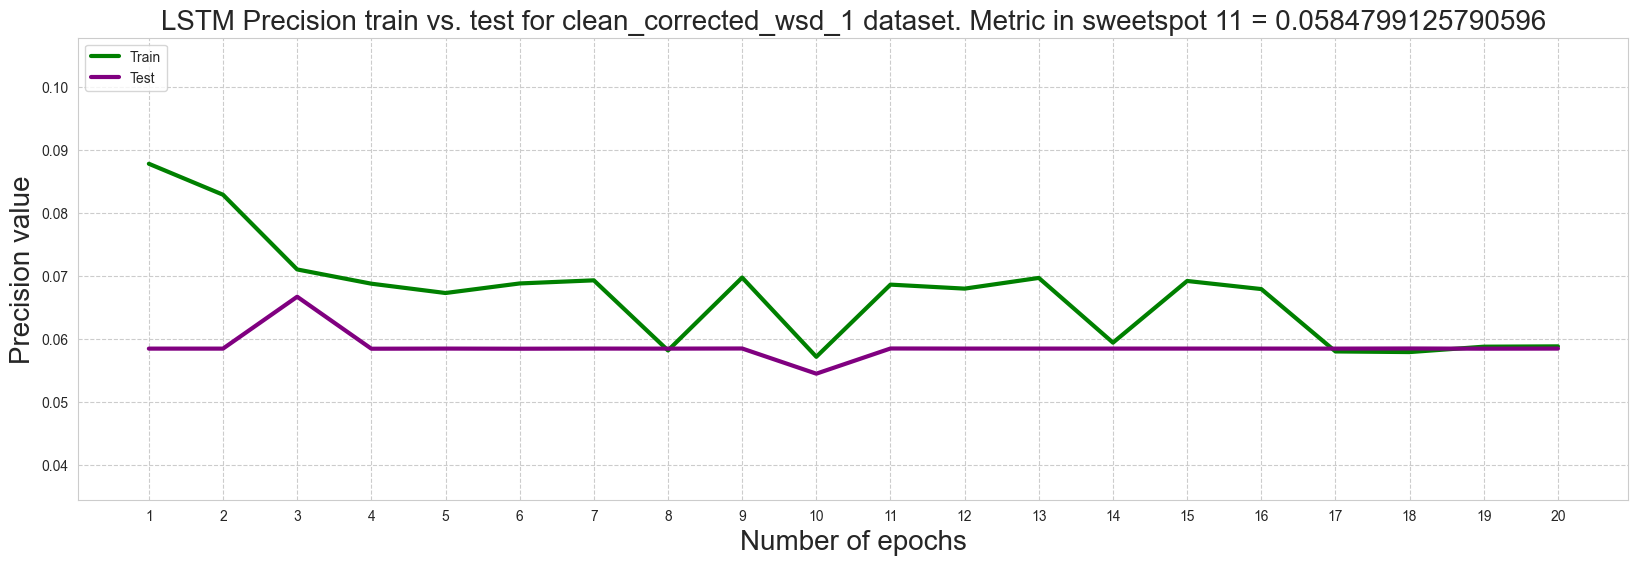

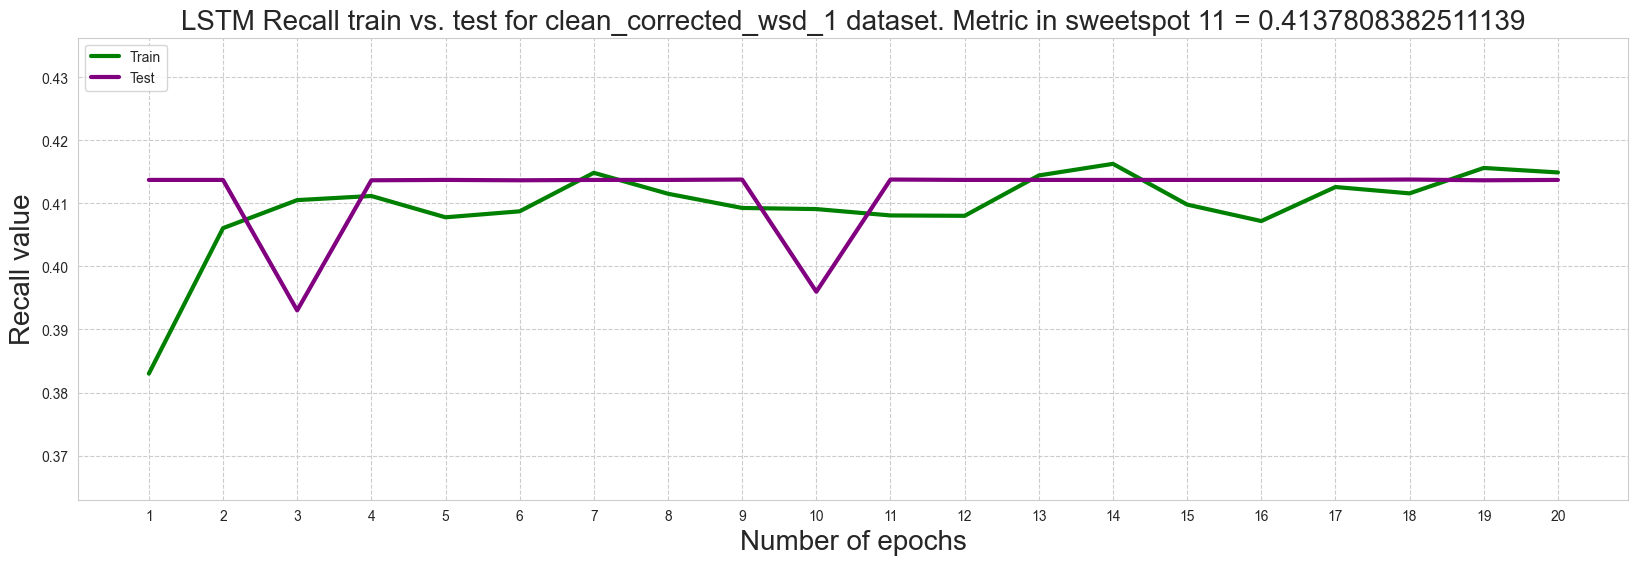

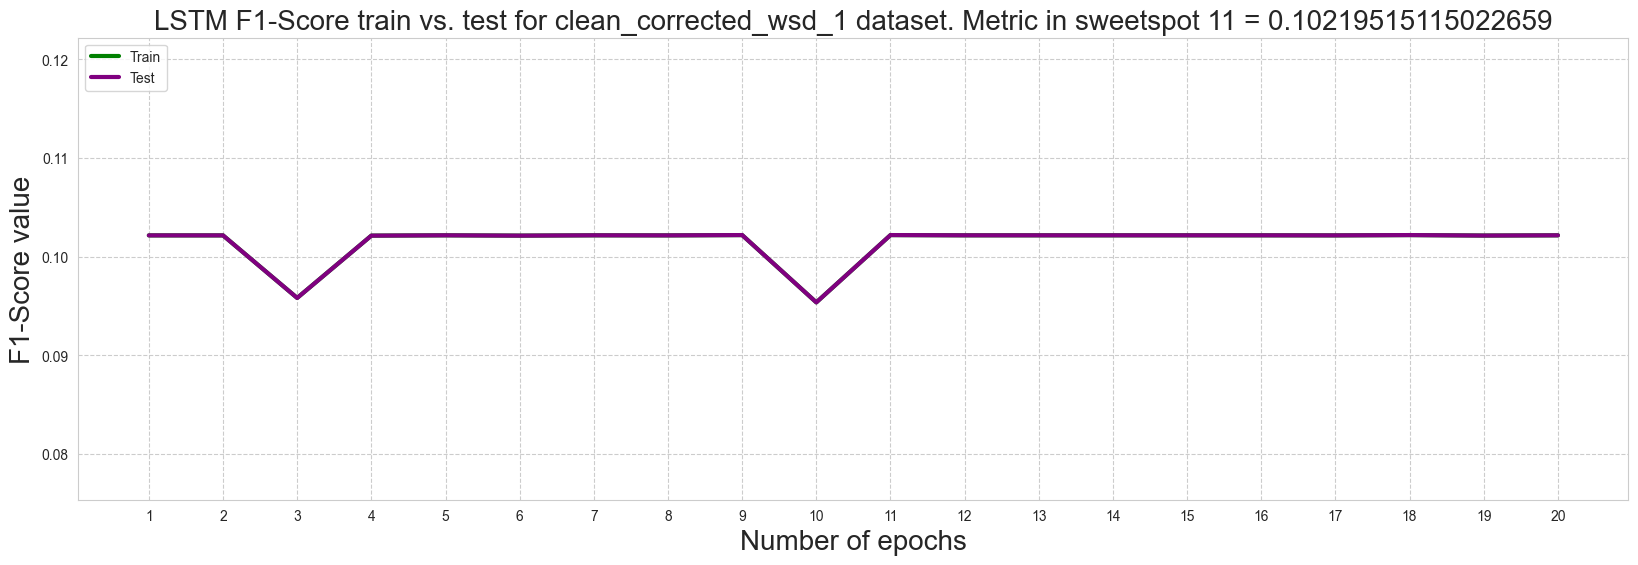

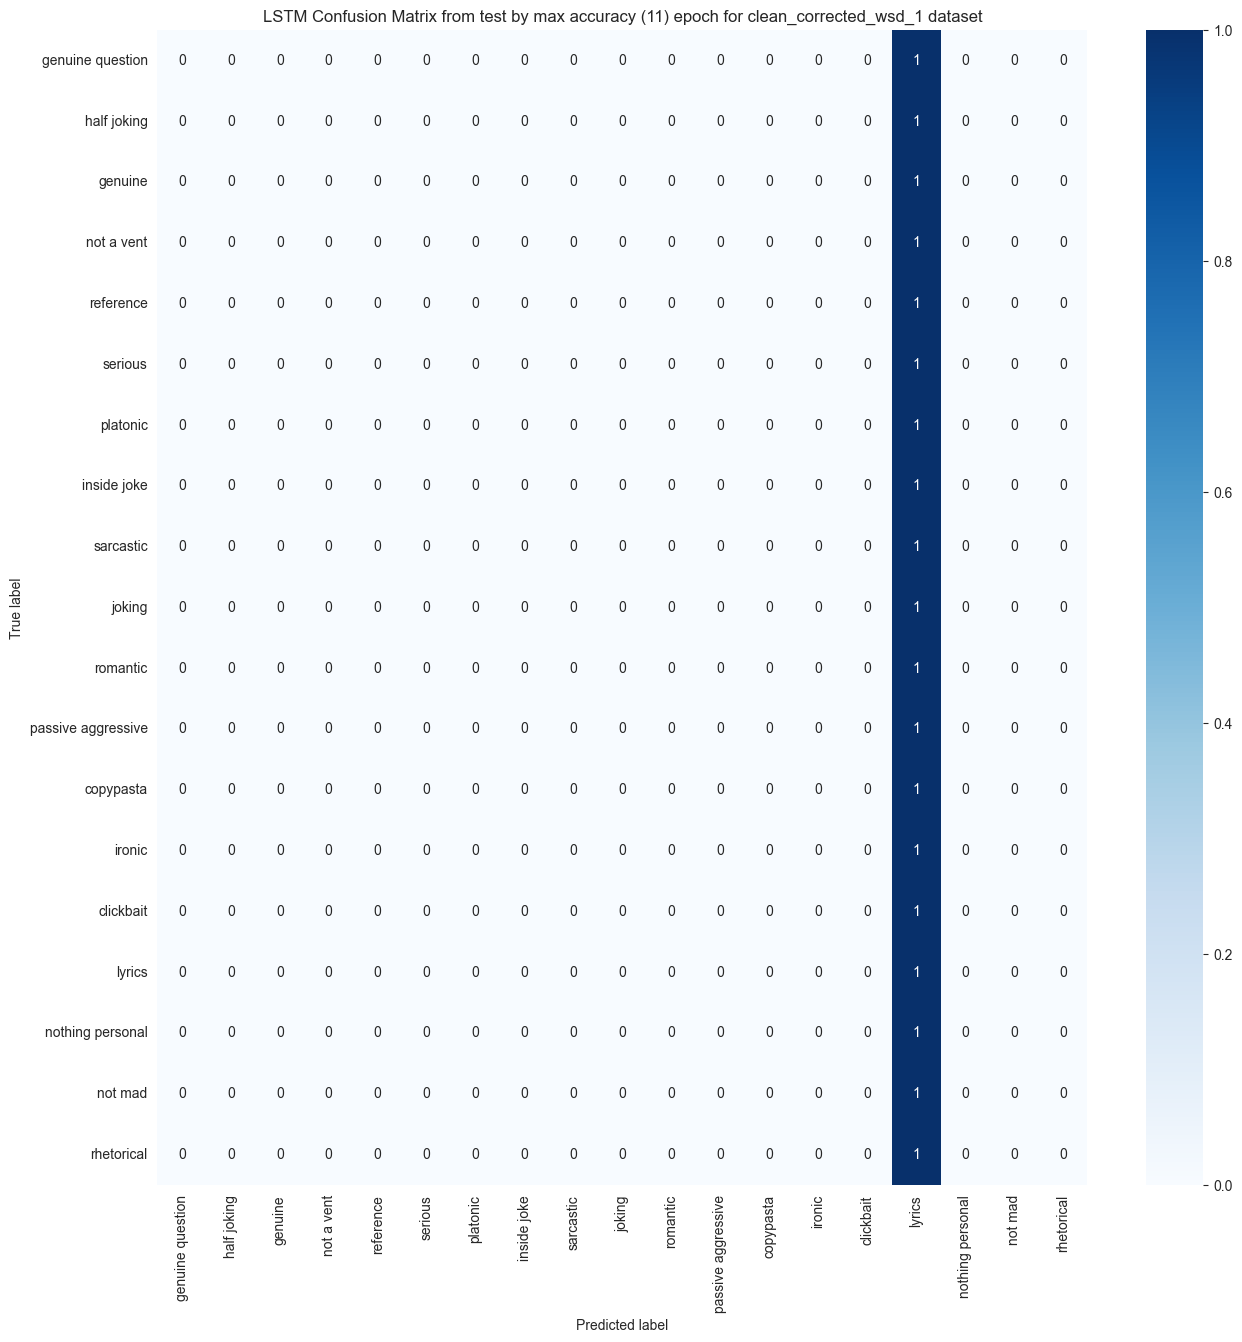

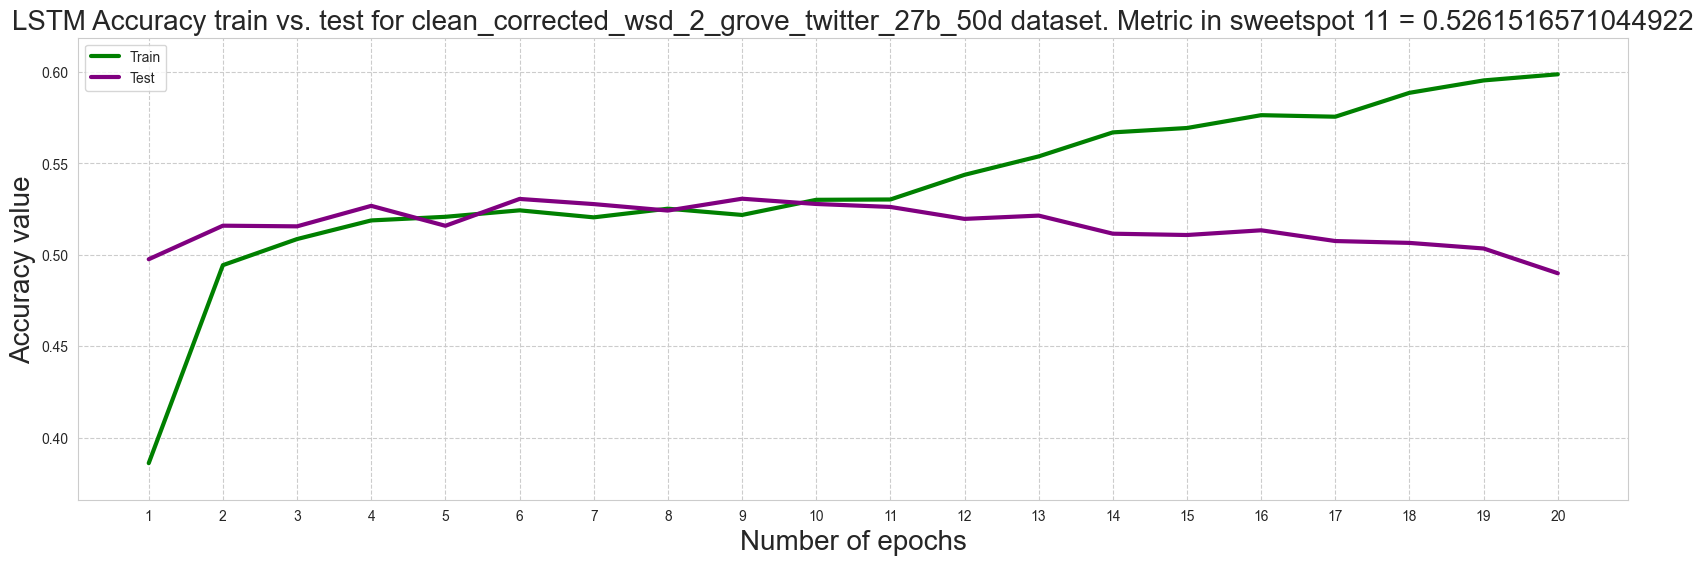

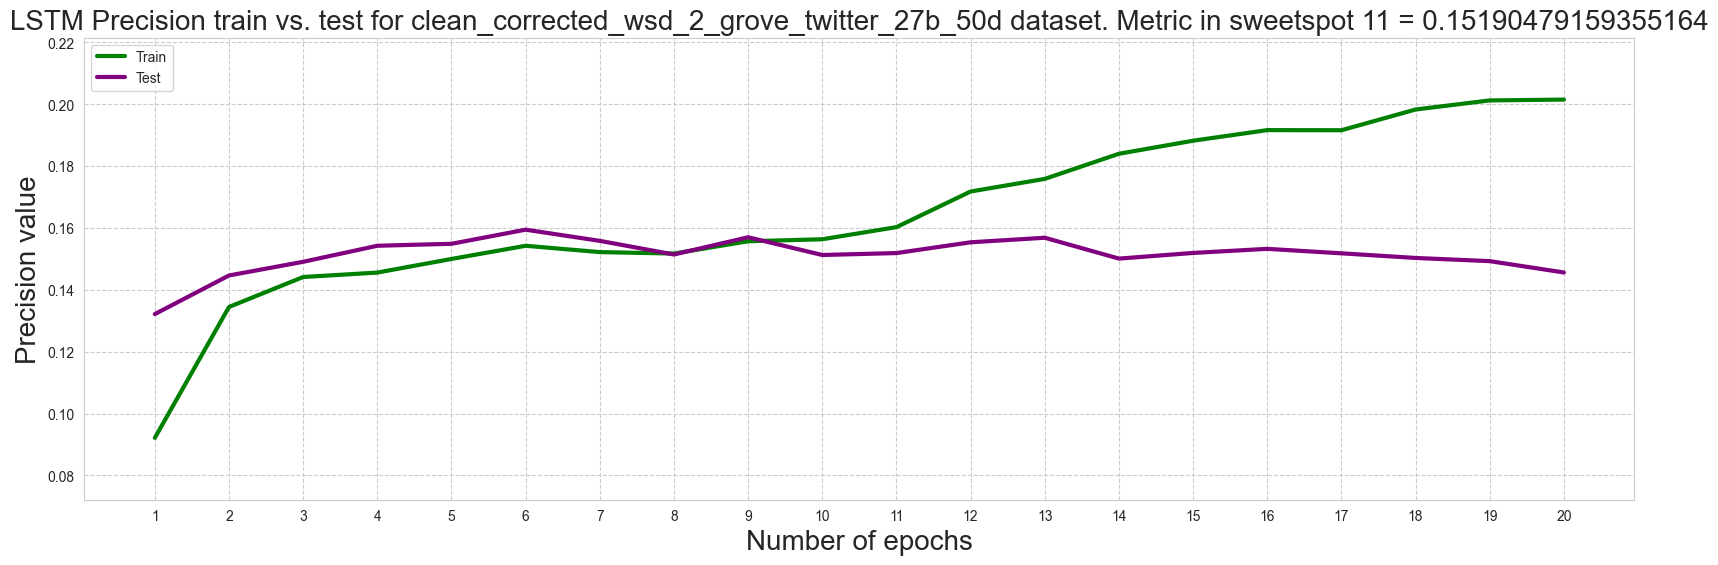

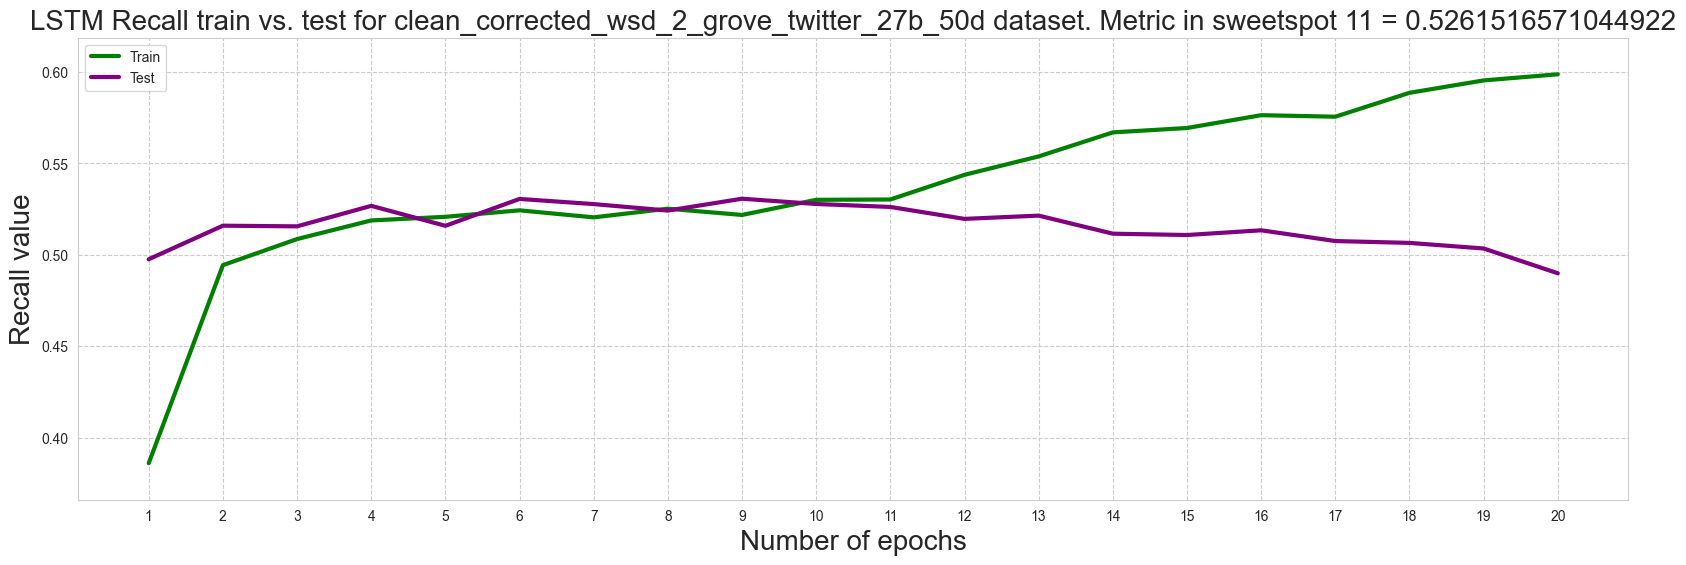

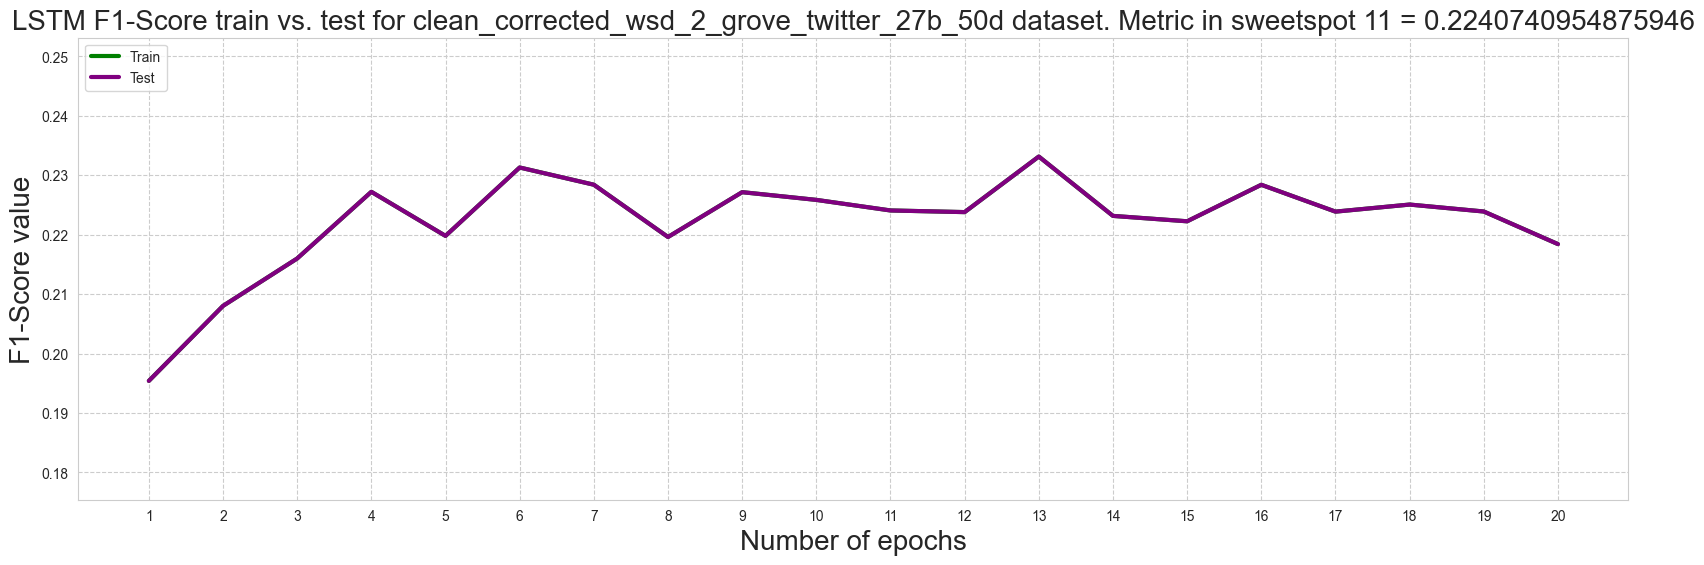

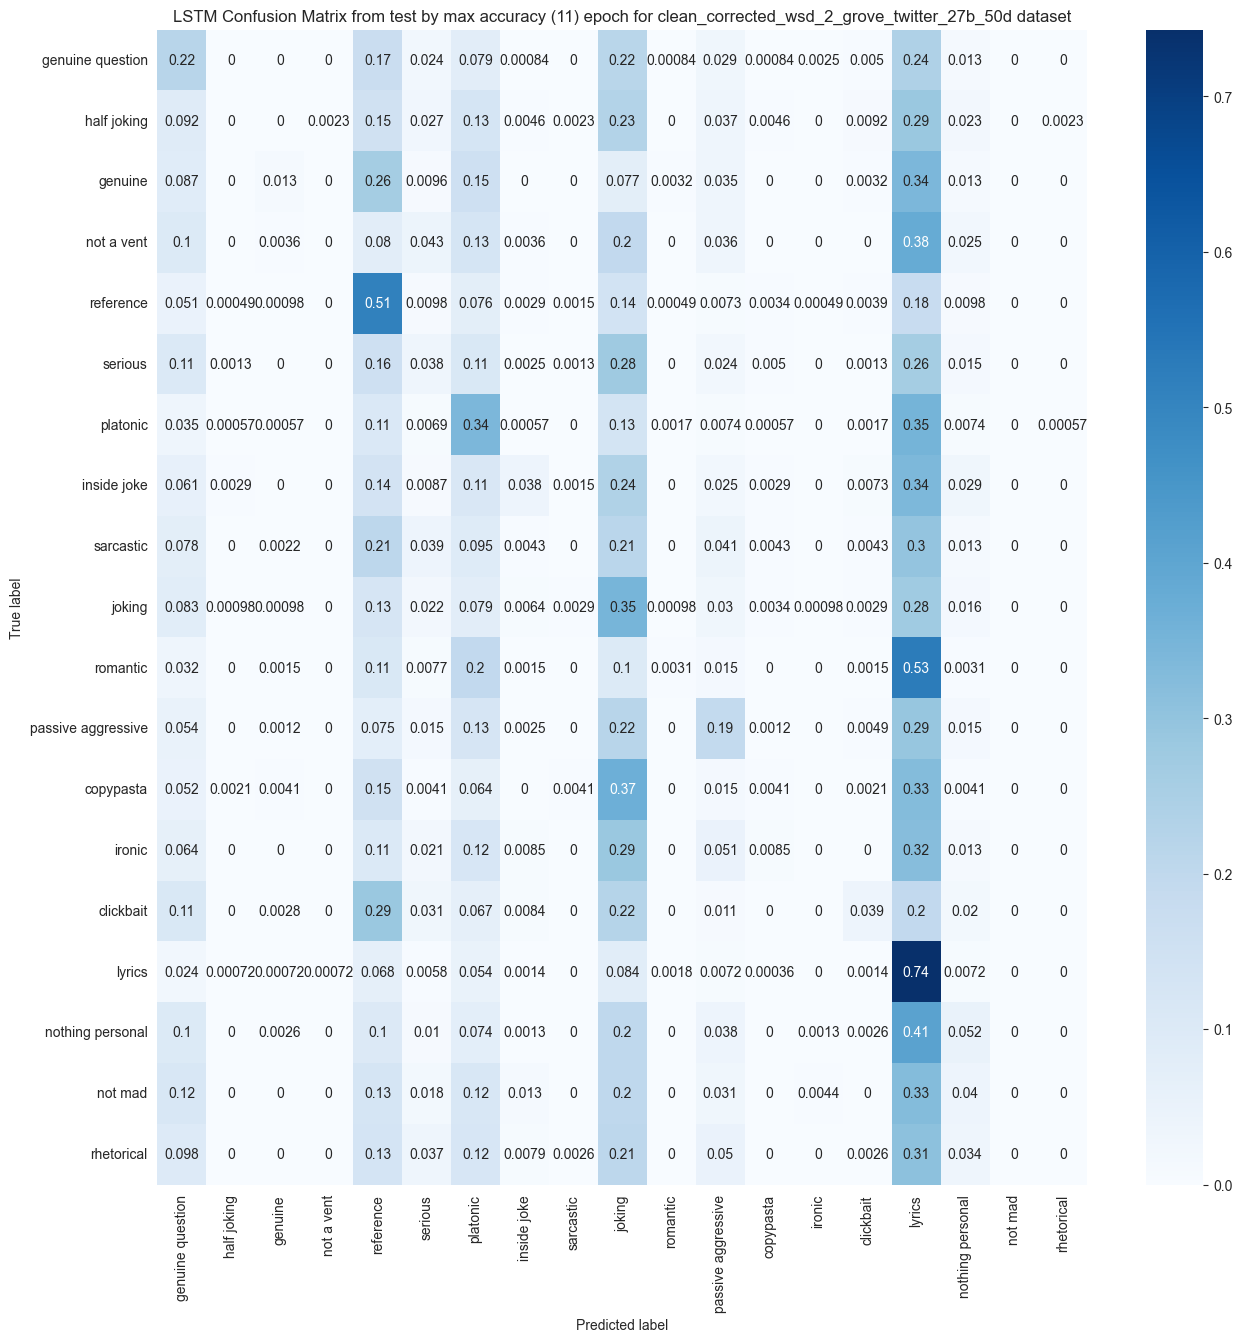

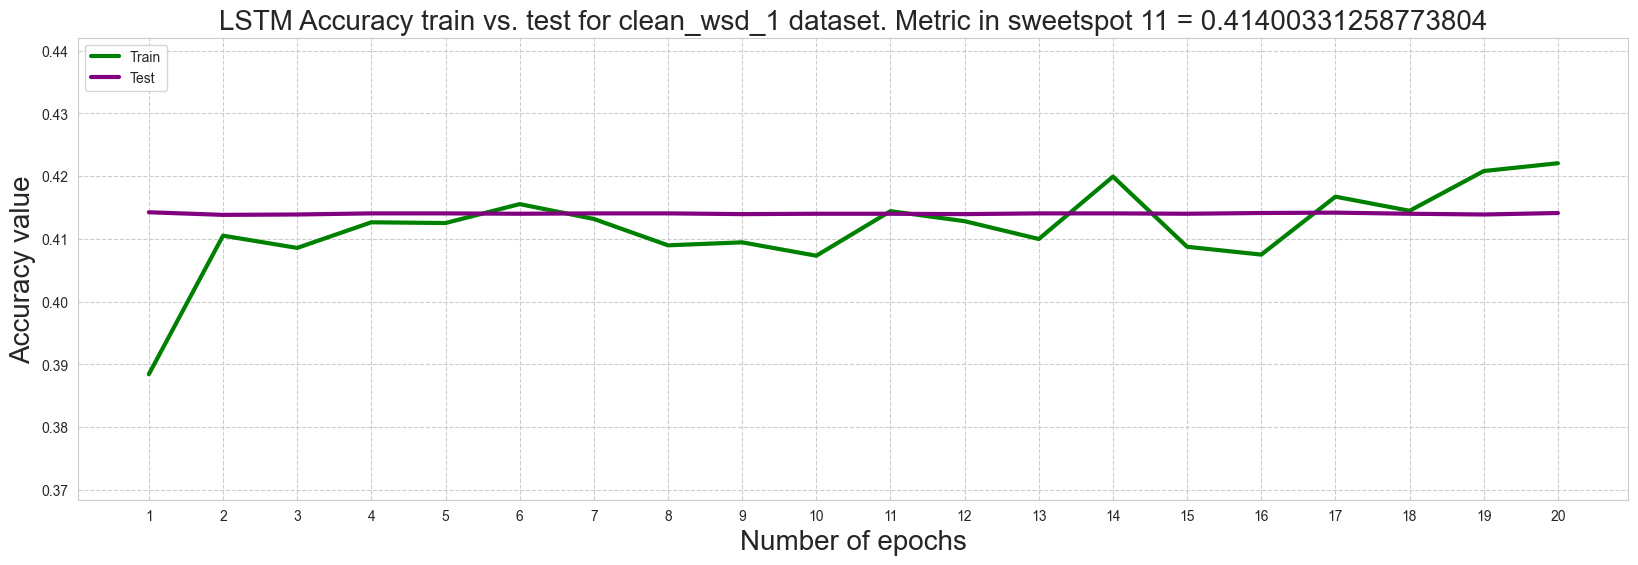

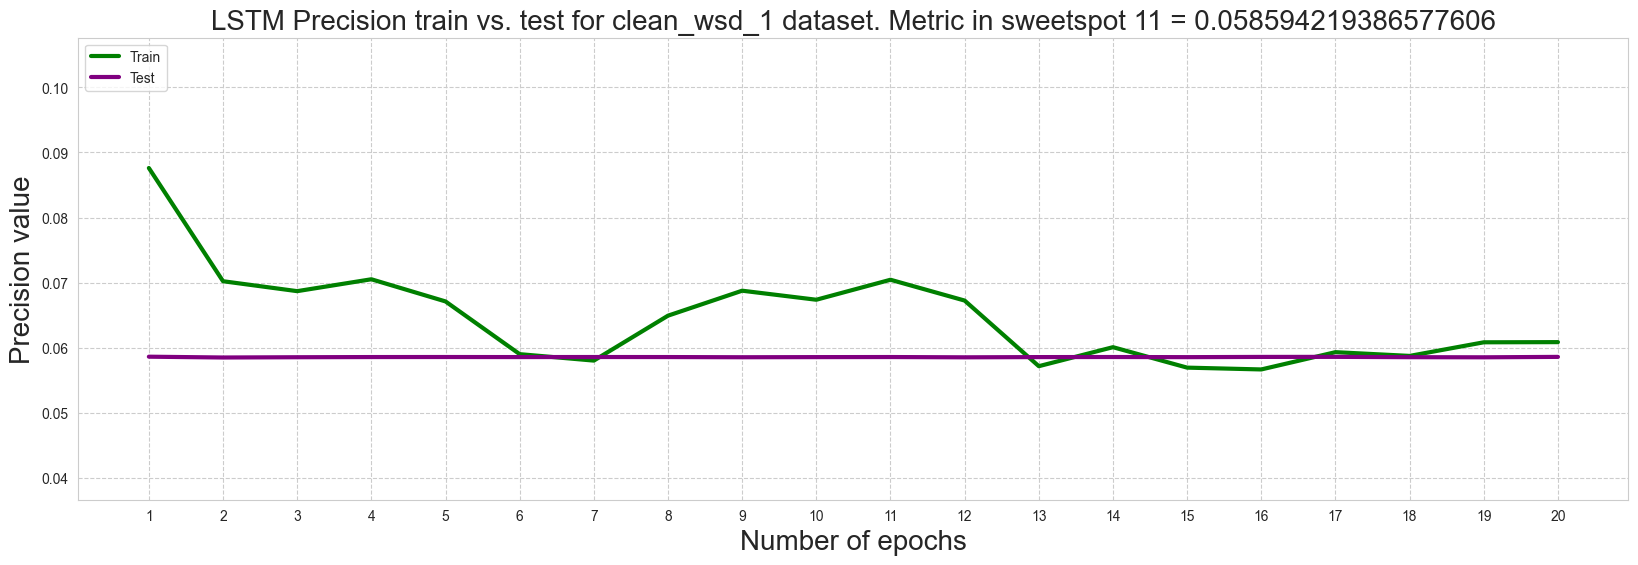

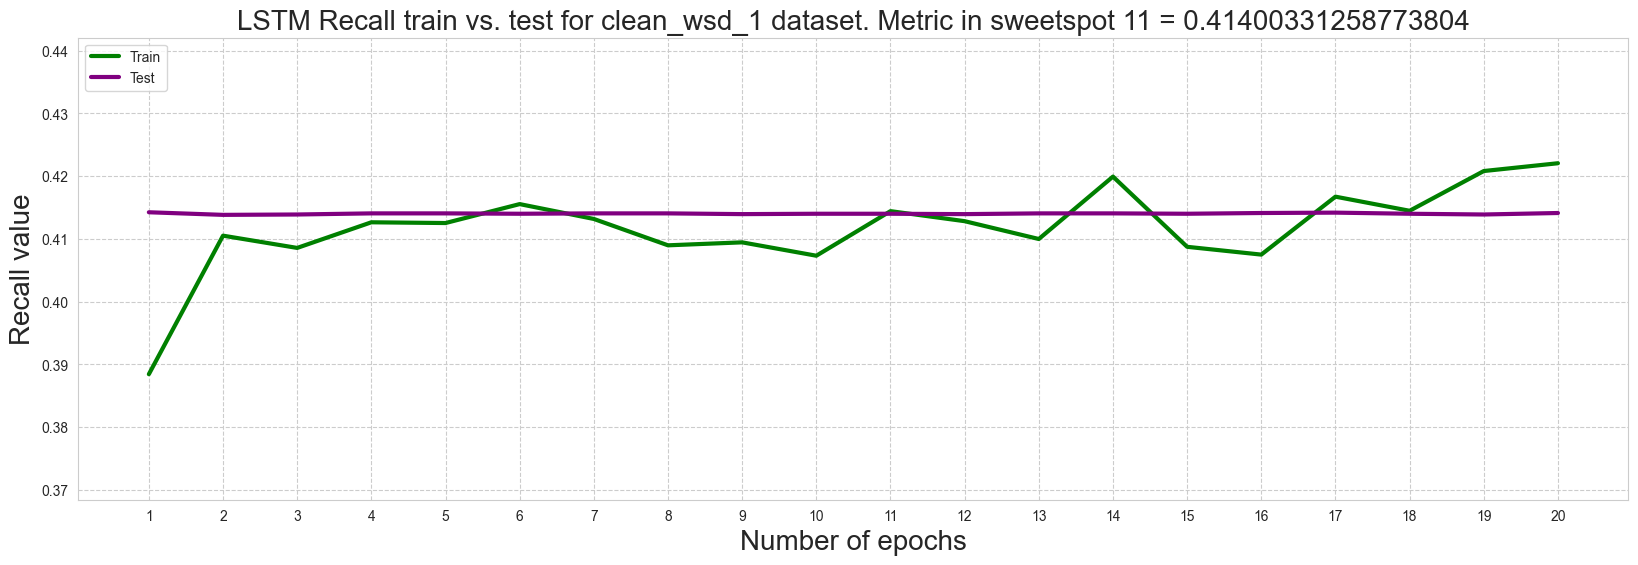

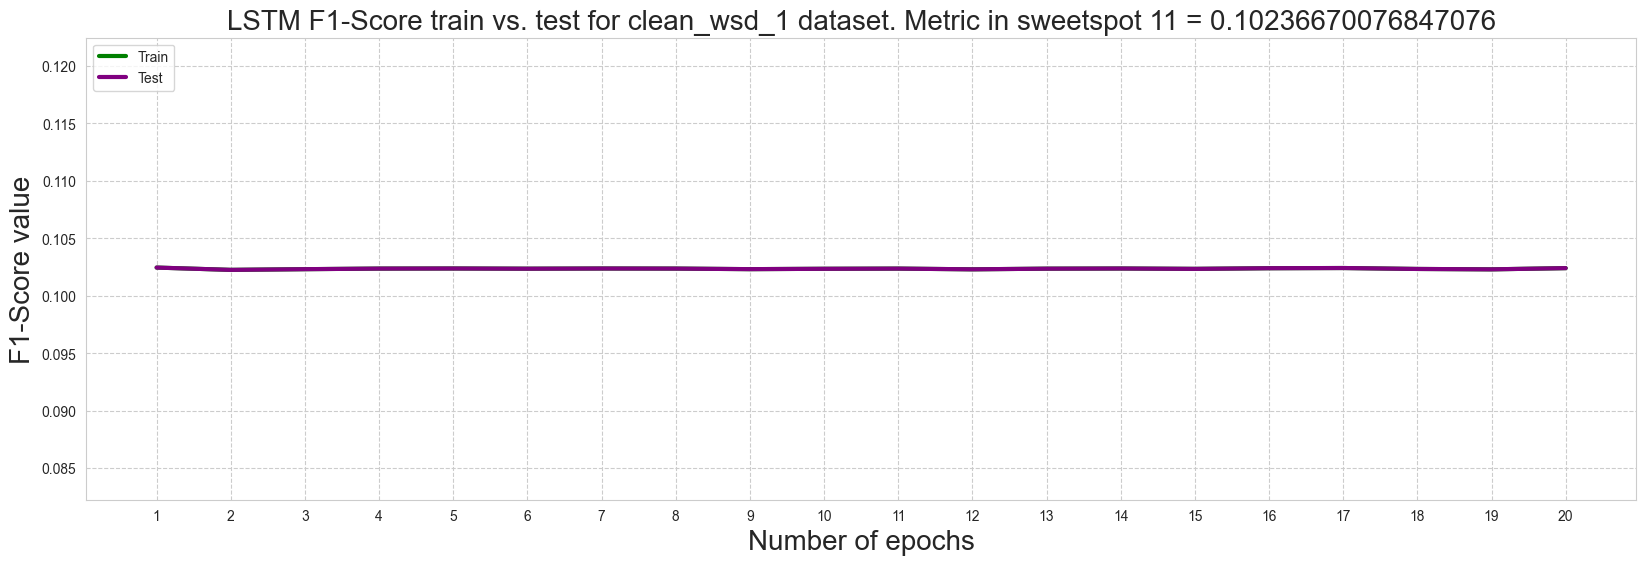

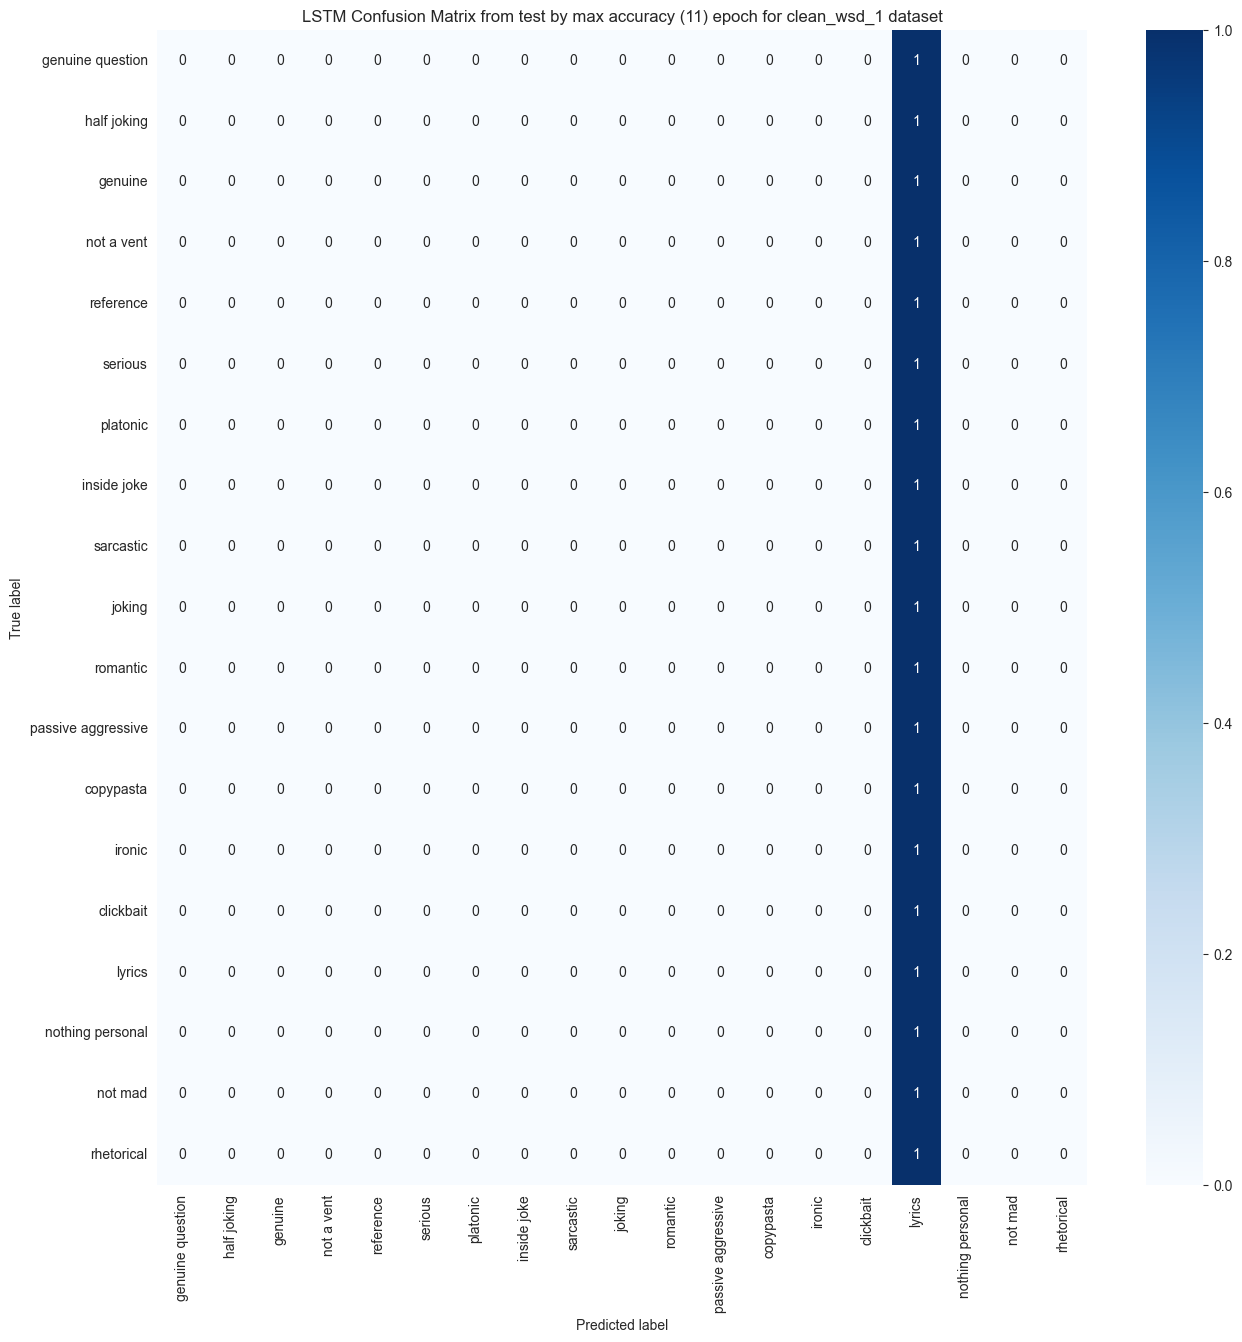

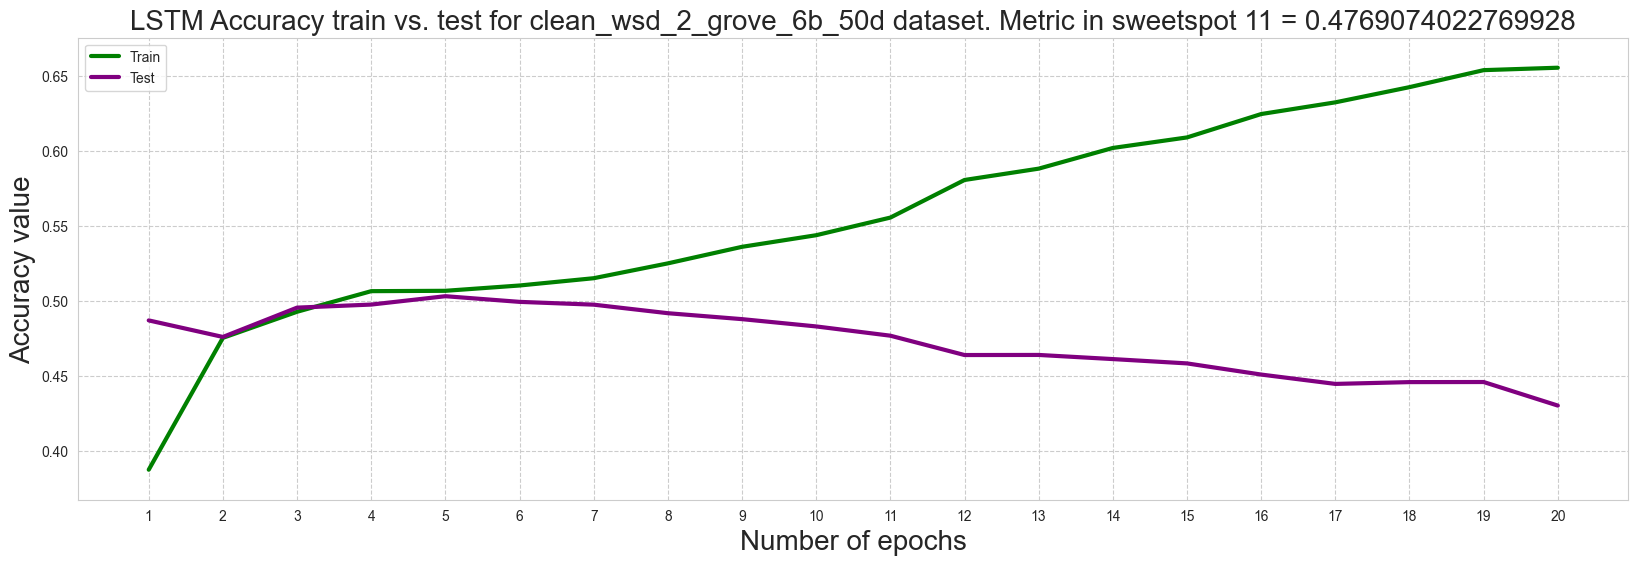

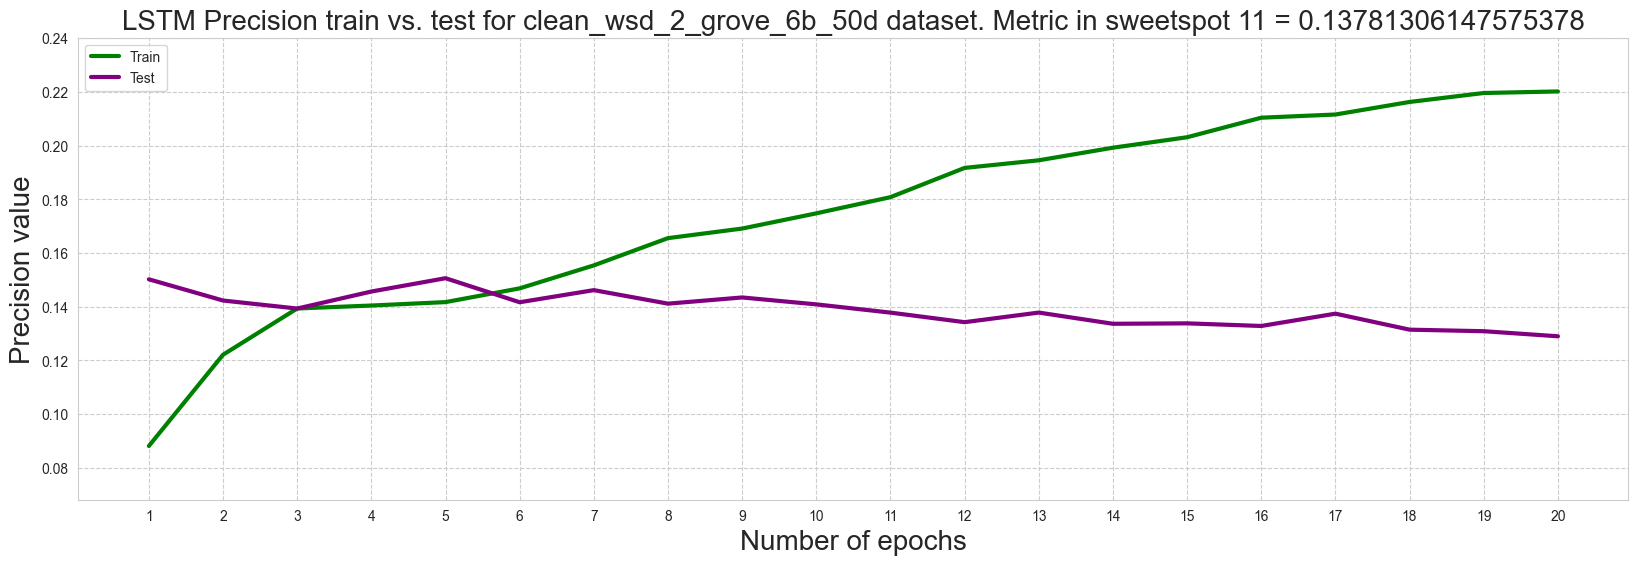

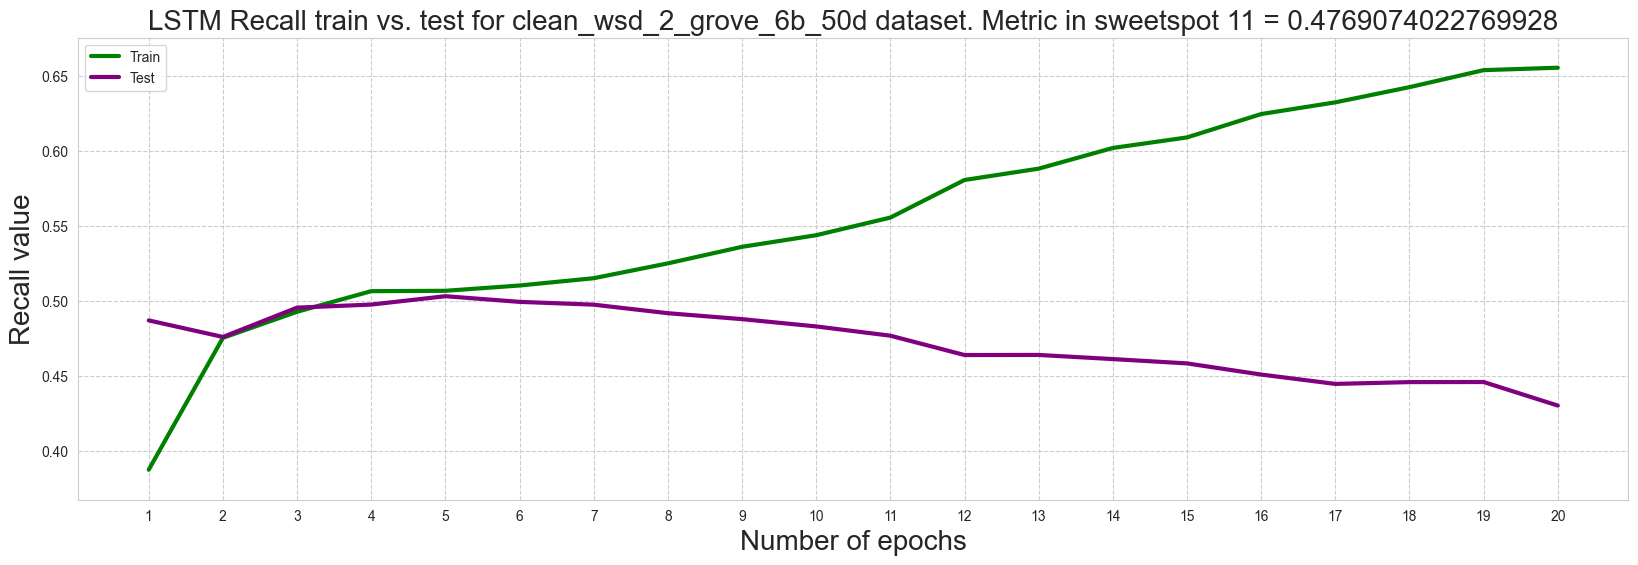

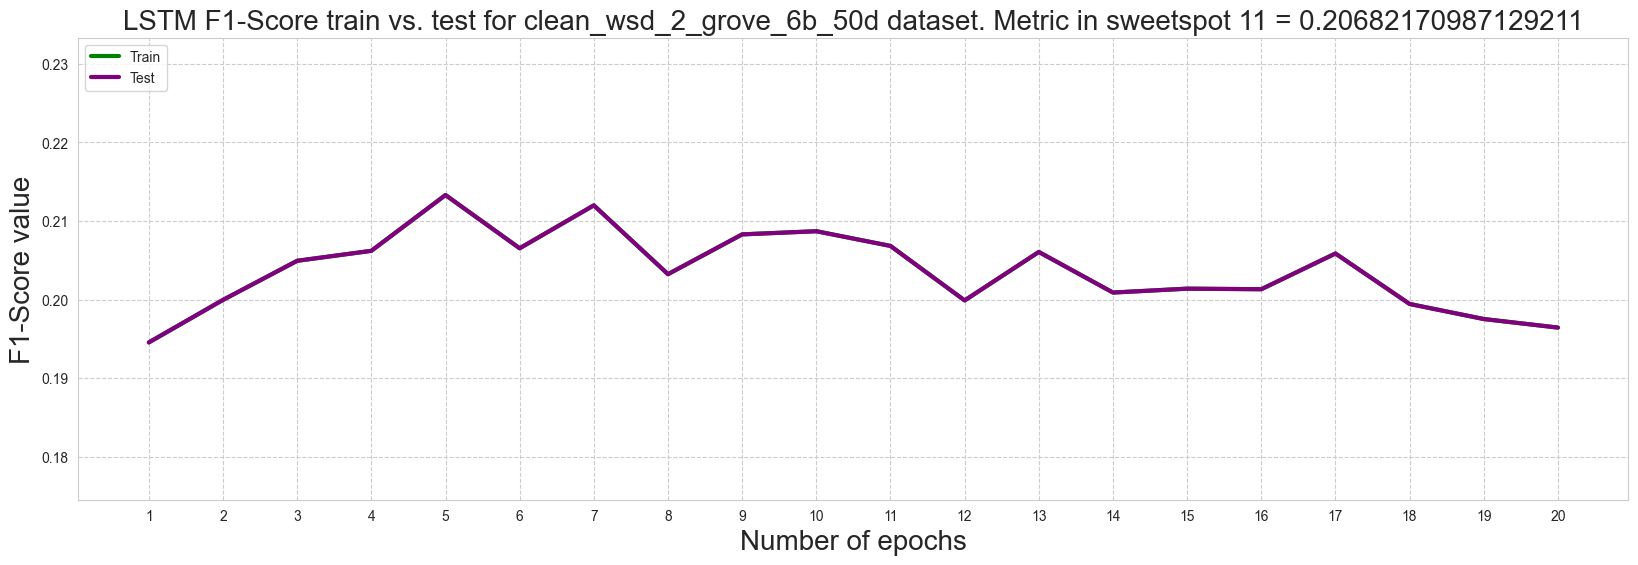

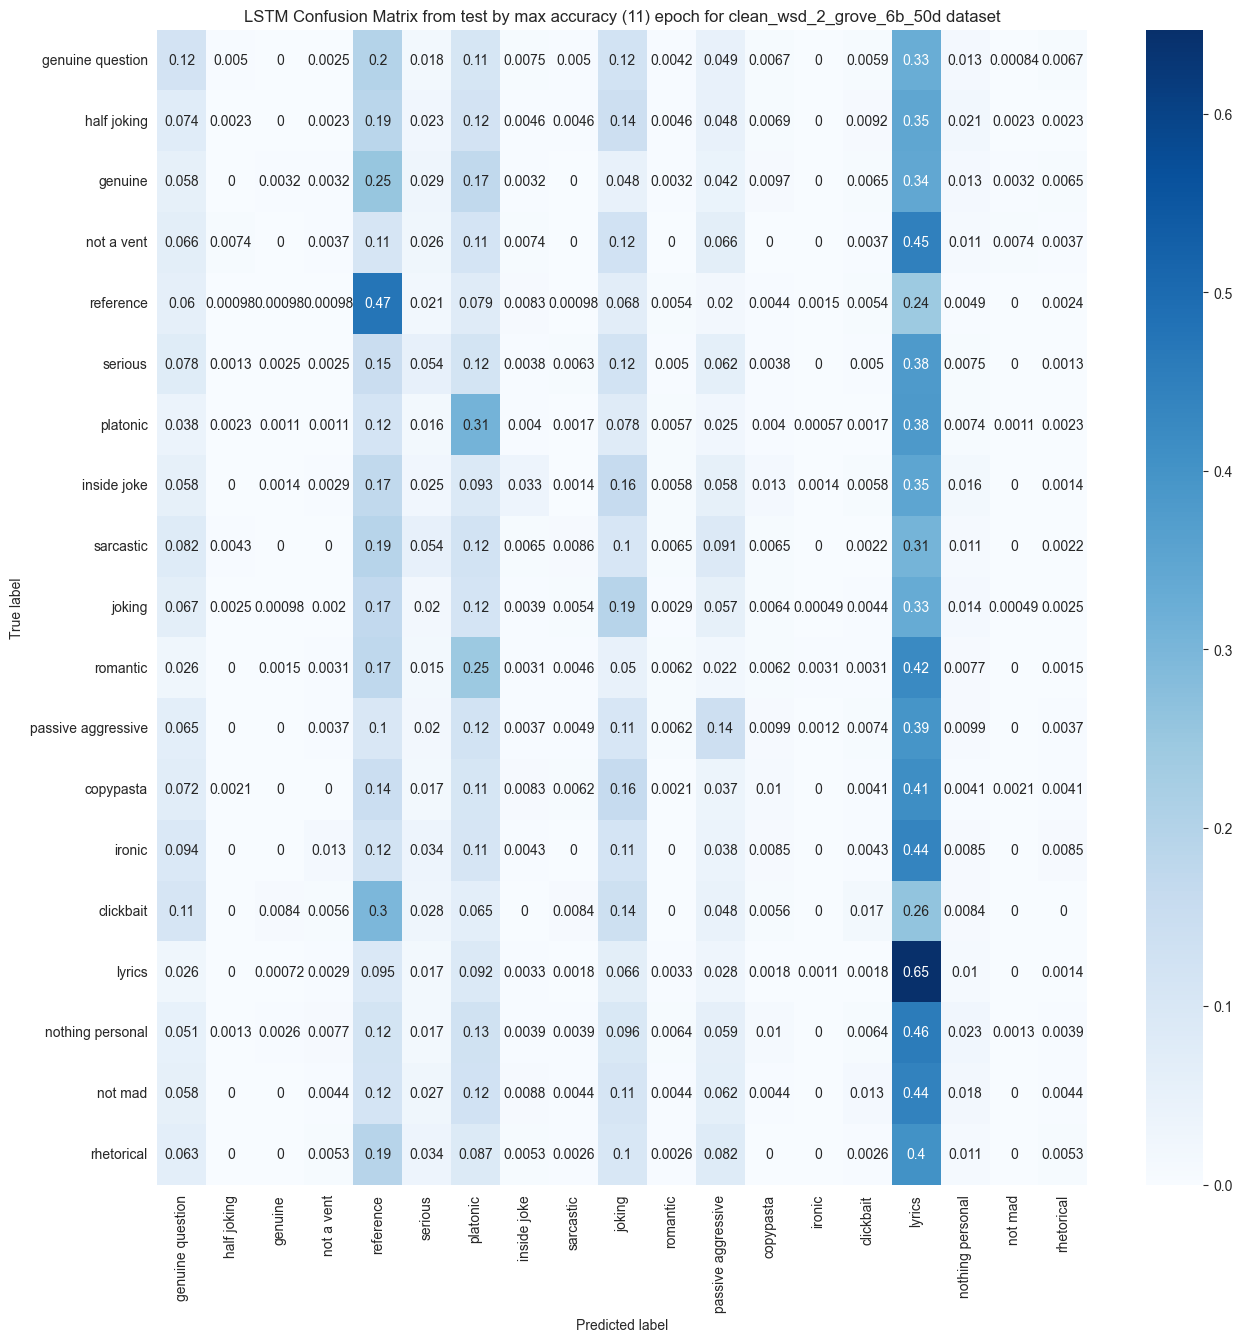

In [56]:
for dataset_name, datasets_by_epochs in results_dfs.items():

    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1scores = []
    train_confusionmatrix = []

    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1scores = []
    test_confusionmatrix = []

    accuracy_func = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes, average='weighted', top_k=3)
    precision_func = torchmetrics.classification.Precision(task='multiclass', num_classes=num_classes, average='weighted', top_k=3)
    recall_func = torchmetrics.classification.Recall(task='multiclass', num_classes=num_classes, average='weighted', top_k=3)
    f1score_func = torchmetrics.classification.F1Score(task='multiclass', num_classes=num_classes, average='weighted', top_k=3)
    confusionmatrix_func = torchmetrics.classification.ConfusionMatrix(task='multiclass', num_classes=num_classes)

    epochs = sorted(datasets_by_epochs.keys())
    for epoch in epochs:
        train_predictions = torch.tensor(datasets_by_epochs[epoch]['train_predictions'], dtype=torch.float)
        test_predictions = torch.tensor(datasets_by_epochs[epoch]['test_predictions'], dtype=torch.float)

        train_tags = torch.tensor(datasets_by_epochs[epoch]['train_tags'], dtype=torch.int)
        test_tags = torch.tensor(datasets_by_epochs[epoch]['test_tags'], dtype=torch.int)

        train_accuracies.append(accuracy_func(train_predictions, train_tags))
        train_precisions.append(precision_func(train_predictions, train_tags))
        train_recalls.append(recall_func(train_predictions, train_tags))
        train_f1scores.append(f1score_func(train_predictions, train_tags))
        train_confusionmatrix.append(confusionmatrix_func(train_predictions, train_tags))

        test_accuracies.append(accuracy_func(test_predictions, test_tags))
        test_precisions.append(precision_func(test_predictions, test_tags))
        test_recalls.append(recall_func(test_predictions, test_tags))
        test_f1scores.append(f1score_func(test_predictions, test_tags))
        test_confusionmatrix.append(confusionmatrix_func(test_predictions, test_tags))

    plot_function(dataset_name, 'Accuracy', train_accuracies, test_accuracies, epochs)
    plot_function(dataset_name, 'Precision', train_precisions, test_precisions, epochs)
    plot_function(dataset_name, 'Recall', train_recalls, test_recalls, epochs)
    plot_function(dataset_name, 'F1-Score', test_f1scores, test_f1scores, epochs)


    max_test_accuracies_index = 11

    for i, _ in enumerate(test_confusionmatrix[max_test_accuracies_index]):
        test_confusionmatrix[max_test_accuracies_index] = test_confusionmatrix[max_test_accuracies_index].type(torch.float)
        test_confusionmatrix[max_test_accuracies_index][i] = test_confusionmatrix[max_test_accuracies_index][i] / torch.sum(test_confusionmatrix[max_test_accuracies_index][i], dtype=torch.float)
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(test_confusionmatrix[max_test_accuracies_index], annot=True, fmt='.2g', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.title(f'LSTM Confusion Matrix from test by max accuracy ({max_test_accuracies_index}) epoch for {dataset_name} dataset')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.show()
    
    # print(test_accuracies[10].item(), test_precisions[10].item(), test_recalls[10].item(), test_f1scores[10].item())